## 문제 정의

YOLOv5를 사용한 색상, 흠집에 대한 이미지 학습으로 등급을 정확하게 분류하기에는 한계가 있음
실제로 무게와 당도가 등급 분류에 영향을 미침
특히 특급, 상급은 비슷한 이미지가 많아 정확성이 30%대로 매우 낮은 수치에 해당함
따라서 무게를 추론 해낼 수 있는 넓이, 높이와 같은 크기 수치와 등급의 상관 관계 분석을 실시

<br>

- 귀무 가설(Null Hypothesis) : 크기와 넓이가 특급, 상급 등급 분류에 영향을 주지 않는다.

- 대안 가설(Alternative Hypothesis) : 크기와 넓이가 특급, 상급 등급 분류에 영향을 준다.

## 데이터 전처리 (Data Preprocessing)

In [115]:
# 사용 라이브러리 임포트
import numpy as np
import pandas as pd
from random import sample
import matplotlib.pyplot as plt

In [116]:
# 데이터 프레임 로드
df = pd.read_csv("data/dataset.csv")
df.head()
# High는 특급, Medium은 상급, Low는 보통급에 해당함

,ImageID,LabelName,Width,Height
0,apple_fuji_L_1,high,9.7,9.0
1,apple_fuji_L_10,high,9.6,8.9
2,apple_fuji_L_11,high,9.4,8.7
3,apple_fuji_L_12,high,9.7,8.7
4,apple_fuji_L_13,high,9.7,9.4


In [117]:
# 특급과 상급을 비교하기 위해 보통은 데이터프레임으로부터 제외
# 여기에 슬라이싱 사용해서 high랑 medium 남게 할것
df_1 = df[df.LabelName != 'low']
df_1

,ImageID,LabelName,Width,Height
0,apple_fuji_L_1,high,9.7,9.0
1,apple_fuji_L_10,high,9.6,8.9
2,apple_fuji_L_11,high,9.4,8.7
3,apple_fuji_L_12,high,9.7,8.7
4,apple_fuji_L_13,high,9.7,9.4
...,...,...,...,...
115,apple_fuji_M_6,medium,8.7,8.1
116,apple_fuji_M_60,medium,8.4,7.5
117,apple_fuji_M_7,medium,8.9,7.9
118,apple_fuji_M_8,medium,8.8,7.9


In [118]:
df_2 = df[df.LabelName != 'high']
df_2

,ImageID,LabelName,Width,Height
60,apple_fuji_M_1,medium,8.6,7.5
61,apple_fuji_M_10,medium,9.5,7.5
62,apple_fuji_M_11,medium,8.8,7.2
63,apple_fuji_M_12,medium,8.6,7.1
64,apple_fuji_M_13,medium,8.1,7.1
...,...,...,...,...
175,apple_fuji_S_6,low,7.8,6.6
176,apple_fuji_S_60,low,7.5,6.5
177,apple_fuji_S_7,low,7.5,7.0
178,apple_fuji_S_8,low,7.8,7.1


In [119]:
df_l = df[df.LabelName == 'low']
df_l.describe()

,Width,Height
count,60.000000,60.000000
mean,7.540000,6.638333
std,0.205187,0.287061
min,7.000000,6.100000
25%,7.400000,6.400000
50%,7.500000,6.550000
75%,7.700000,6.900000
max,7.900000,7.200000


## 탐색적 데이터 분석 (EDA)

### 데이터 분석 (Data analysis)

In [120]:
df_1.keys()

Index(['ImageID', 'LabelName', 'Width', 'Height'], dtype='object')

In [121]:
# 특급과 상급 크기, 넓이 평균값 비교
df_1.describe()

,Width,Height
count,120.000000,120.000000
mean,9.107500,8.291667
std,0.581531,0.668447
min,8.100000,7.100000
25%,8.700000,7.700000
50%,9.050000,8.300000
75%,9.500000,8.825000
max,10.500000,9.500000


In [122]:
df_h = df_1[df_1.LabelName == 'high']

In [123]:
df_h.describe()

,Width,Height
count,60.000000,60.000000
mean,9.590000,8.878333
std,0.336835,0.308683
min,9.000000,8.200000
25%,9.400000,8.675000
50%,9.500000,8.850000
75%,9.800000,9.025000
max,10.500000,9.500000


In [124]:
df_m = df_1[df_1.LabelName == 'medium']

In [125]:
df_m.describe()

,Width,Height
count,60.000000,60.000000
mean,8.625000,7.705000
std,0.308427,0.325433
min,8.100000,7.100000
25%,8.400000,7.500000
50%,8.700000,7.700000
75%,8.800000,8.000000
max,9.500000,8.600000


### 시각화(Visualization)

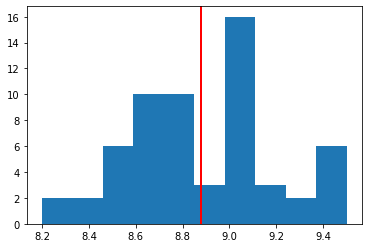

In [126]:
# 등급에 따른 Height 분포 (히스토그램 사용)
plt.hist(df_h['Height'])
plt.axvline(x = df_h['Height'].mean(), linewidth = 2, color = 'r')
plt.show()

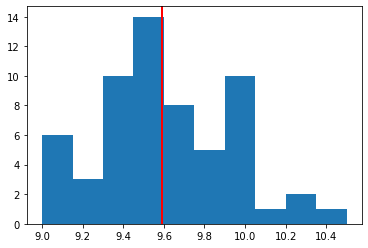

In [127]:
# 등급에 따른 width 분포 (히스토그램 사용)
plt.hist(df_h['Width'])
plt.axvline(x = df_h['Width'].mean(), linewidth = 2, color = 'r')
plt.show()

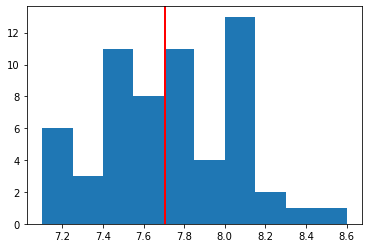

In [128]:
plt.hist(df_m['Height'])
plt.axvline(x = df_m['Height'].mean(), linewidth = 2, color = 'r')
plt.show()

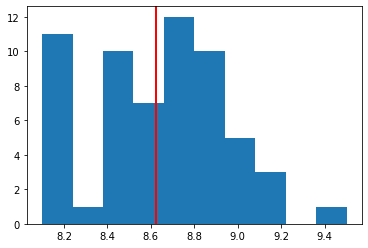

In [129]:
plt.hist(df_m['Width'])
plt.axvline(x = df_m['Width'].mean(), linewidth = 2, color = 'r')
plt.show()

### 순열검정법 (Permutation test)

##### 전체 순열 검정법 (exhaustive permutation test)
- 만약 히스토그램의 분포도가 정규 분포에 해당하면 실시
##### 부트스트래핑 (Bootstrapping)
- 만약 히스토그램의 분포도가 정규 분포에 해당하지 않으면 실시

##### 두 방법의 차이점
- 전체 순열 검정은 재표본추출(샘플링) 할때 중복 되지 않도록 한다. 했던 것을 다시 뽑으면 안됨
- 부트스트래핑은 재표본추출(샘플링) 할때 중복 될 수도 있도록 한다. 했던 것을 다시 뽑아도 됨


#### 크기(Height) 테스트

In [130]:
# 관측치 = 특급과 상급의 높이 차이점
pivot_tb = pd.pivot_table(df_1, values="Height",index=['LabelName'], aggfunc=np.mean)
obs = (pivot_tb.values[0] - pivot_tb.values[1])[0]# 관측치 계산(observation) - 특급의 평균 크기
obs

1.1733333333333338

In [131]:
# 랜덤 셔플링 코드
# 1000번 샘플링을 할것
N = 1000
# 특급의 갯수
size = df_1[df_1['LabelName']=='high'].shape[0]
#
def perm_test(table):
    # 섞는 과정
    shuffled_col = (table['LabelName'].sample(replace=False,frac=1).reset_index(drop=True))
    added_shuffle = table.assign(**{'shuffled': shuffled_col})
    mean_diff = pd.pivot_table(added_shuffle, values="Height",index=['shuffled'], aggfunc=np.mean)
    mean_diff = (mean_diff.values[0] - mean_diff.values[1])[0]
    return mean_diff

results = [perm_test(df_1) for i in np.arange(N)]

In [132]:
# p-value 계산
simul = pd.Series(np.array(results))
p_val = np.count_nonzero(simul >= obs)/1000
p_val

0.0

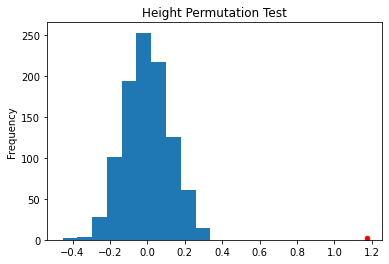

In [133]:
# 시각화
pd.Series(simul).plot(kind='hist', title='Height Permutation Test')
plt.scatter(obs,2,color='r',s=20)

#### 넓이(Width) 테스트

In [134]:
# 관측치 = 특급과 상급의 높이 차이점
pivot_tb = pd.pivot_table(df_1, values="Width",index=['LabelName'], aggfunc=np.mean)
obs = (pivot_tb.values[0] - pivot_tb.values[1])[0]# 관측치 계산(observation) - 특급의 평균 크기
obs

0.9649999999999999

In [135]:
# 랜덤 셔플링 코드
# 1000번 샘플링을 할것
N = 1000
# 특급의 갯수
size = df_1[df_1['LabelName']=='high'].shape[0]
#
def perm_test(table):
    # 섞는 과정
    shuffled_col = (table['LabelName'].sample(replace=False,frac=1).reset_index(drop=True))
    added_shuffle = table.assign(**{'shuffled': shuffled_col})
    mean_diff = pd.pivot_table(added_shuffle, values="Width",index=['shuffled'], aggfunc=np.mean)
    mean_diff = (mean_diff.values[0] - mean_diff.values[1])[0]
    return mean_diff

results = [perm_test(df_1) for i in np.arange(N)]

In [136]:
# p-value 계산
simul = pd.Series(np.array(results))
p_val = np.count_nonzero(simul >= obs)/1000
p_val

0.0

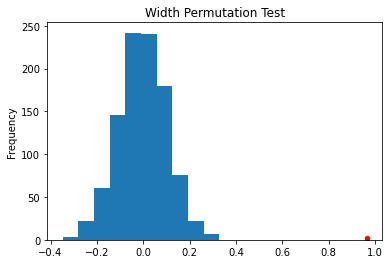

In [137]:
# 시각화
pd.Series(simul).plot(kind='hist', title='Width Permutation Test')
plt.scatter(obs,2,color='r',s=20)

#### 상급과 보통 비교

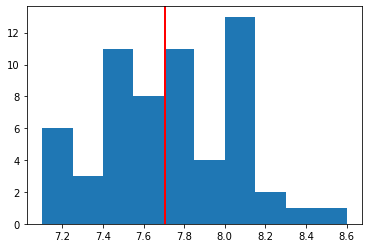

In [138]:
plt.hist(df_m['Height'])
plt.axvline(x = df_m['Height'].mean(), linewidth = 2, color = 'r')
plt.show()

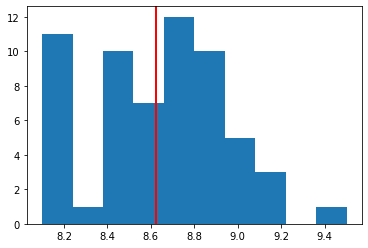

In [139]:
plt.hist(df_m['Width'])
plt.axvline(x = df_m['Width'].mean(), linewidth = 2, color = 'r')
plt.show()

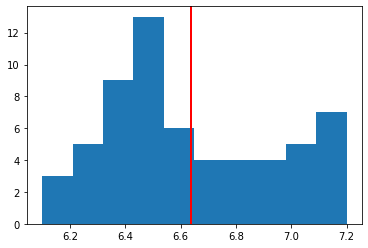

In [140]:
plt.hist(df_l['Height'])
plt.axvline(x = df_l['Height'].mean(), linewidth = 2, color = 'r')
plt.show()

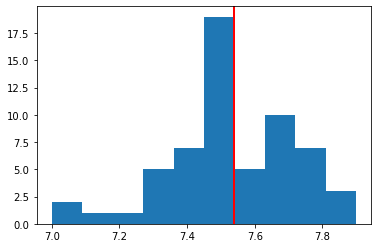

In [141]:
plt.hist(df_l['Width'])
plt.axvline(x = df_l['Width'].mean(), linewidth = 2, color = 'r')
plt.show()

#### 크기(Height) 테스트

In [150]:
# 관측치 = 특급과 상급의 높이 차이점
pivot_tb = pd.pivot_table(df_2, values="Height",index=['LabelName'], aggfunc=np.mean)
obs = (pivot_tb.values[1] - pivot_tb.values[0])[0]# 관측치 계산(observation) - 특급의 평균 크기
obs

1.0666666666666664

In [151]:
# 랜덤 셔플링 코드
# 1000번 샘플링을 할것
N = 1000
# 특급의 갯수
size = df_2[df_2['LabelName']=='medium'].shape[0]
#
def perm_test(table):
    # 섞는 과정
    shuffled_col = (table['LabelName'].sample(replace=False,frac=1).reset_index(drop=True))
    added_shuffle = table.assign(**{'shuffled': shuffled_col})
    mean_diff = pd.pivot_table(added_shuffle, values="Height",index=['shuffled'], aggfunc=np.mean)
    mean_diff = (mean_diff.values[1] - mean_diff.values[0])[0]
    return mean_diff

results = [perm_test(df_2) for i in np.arange(N)]

In [152]:
# p-value 계산
simul = pd.Series(np.array(results))
p_val = np.count_nonzero(simul >= obs)/1000
p_val

0.0

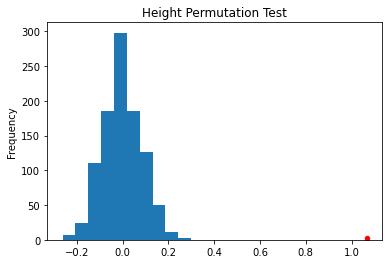

In [153]:
# 시각화
pd.Series(simul).plot(kind='hist', title='Height Permutation Test')
plt.scatter(obs,2,color='r',s=20)

In [156]:
# 관측치 = 특급과 상급의 높이 차이점
pivot_tb = pd.pivot_table(df_2, values="Width",index=['LabelName'], aggfunc=np.mean)
obs = (pivot_tb.values[1] - pivot_tb.values[0])[0]# 관측치 계산(observation) - 특급의 평균 크기
obs

1.085

In [157]:
# 랜덤 셔플링 코드
# 1000번 샘플링을 할것
N = 1000
# 특급의 갯수
size = df_2[df_2['LabelName']=='medium'].shape[0]
#
def perm_test(table):
    # 섞는 과정
    shuffled_col = (table['LabelName'].sample(replace=False,frac=1).reset_index(drop=True))
    added_shuffle = table.assign(**{'shuffled': shuffled_col})
    mean_diff = pd.pivot_table(added_shuffle, values="Width",index=['shuffled'], aggfunc=np.mean)
    mean_diff = (mean_diff.values[1] - mean_diff.values[0])[0]
    return mean_diff

results = [perm_test(df_2) for i in np.arange(N)]

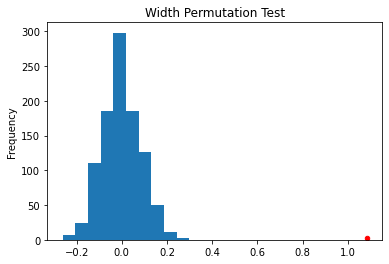

In [158]:
# 시각화
pd.Series(simul).plot(kind='hist', title='Width Permutation Test')
plt.scatter(obs,2,color='r',s=20)